# BirdCLEF 2024 [Inference]

This notebook implements the inference and submission. You can find the pre-processing and training in another notebook attached with this file.

## Features
- PyTorch's Dataset & Dataloader
- Use PyTorch-Lightning for building model

# Import Packages

In [1]:
import re
import os
import gc
import sys
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import librosa
from scipy import signal as sci_signal

import torch
from torch import nn
from torchvision.models import efficientnet

import albumentations as albu

import pytorch_lightning as pl
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Configuration

In [2]:
class config:
    
    # == global config ==
    SEED = 2024  # random seed
    DEVICE = 'cpu'  # device to be used
    MIXED_PRECISION = False  # whether to use mixed-16 precision
    OUTPUT_DIR = '/kaggle/working/'  # output folder
    
    # == data config ==
    DATA_ROOT = '/kaggle/input/birdclef-2024'  # root folder
    Load_DATA = False  # whether to load data from pre|-processed dataset
    FS = 32000  # sample rate
    N_FFT = 1095  # n FFT of Spec.
    WIN_SIZE = 412  # WIN_SIZE of Spec.
    WIN_LAP = 100  # overlap of Spec.
    MIN_FREQ = 40  # min frequency
    MAX_FREQ = 15000  # max frequency
    
    # == model config ==
    MODEL_TYPE = 'efficientnet_b0'  # model type
    
    # == dataset config ==
    BATCH_SIZE = 64  # batch size of each step
    N_WORKERS = 4  # number of workers
    
    # == inference config ==
    CKPT_ROOT = '/kaggle/input/birdclef24-baseline-checkpoints'
    
    # == other config ==
    VISUALIZE = True  # whether to visualize data and batch
    
print('fix seed')
pl.seed_everything(config.SEED, workers=True)

fix seed


2024

In [3]:
# labels
label_list = sorted(os.listdir(os.path.join(config.DATA_ROOT, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

# Dataset & Dataloader

## Pre-Processing

In [4]:
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

In [5]:
all_bird_data = dict()

if len(glob(f'{config.DATA_ROOT}/test_soundscapes/*.ogg')) > 0:
    ogg_file_paths = glob(f'{config.DATA_ROOT}/test_soundscapes/*.ogg')
else:
    ogg_file_paths = sorted(glob(f'{config.DATA_ROOT}/unlabeled_soundscapes/*.ogg'))[:10]

for i, file_path in tqdm(enumerate(ogg_file_paths)):
    row_id = re.search(r'/([^/]+)\.ogg$', file_path).group(1)  # filename
    audio_data, _ = librosa.load(file_path, sr=config.FS)
    
    # to spec.
    spec = oog2spec_via_scipy(audio_data)
    
    # pad
    pad = 512 - (spec.shape[1] % 512)
    if pad > 0:
        spec = np.pad(spec, ((0,0), (0,pad)))
    
    # reshape
    spec = spec.reshape(512,-1,512).transpose([0, 2, 1])
    spec = cv2.resize(spec, (256, 256), interpolation=cv2.INTER_AREA)
    
    for j in range(48):
        all_bird_data[f'{row_id}_{(j+1)*5}'] = spec[:, :, j]

0it [00:00, ?it/s]

## Dataset

In [6]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        bird_data,
        augmentation=None,
    ):
        super().__init__()
        self.bird_data = bird_data
        self.keys_list = list(bird_data.keys())
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.bird_data)
    
    def __getitem__(self, index):
        
        _spec = self.bird_data[self.keys_list[index]]
        
        if self.augmentation is not None:
            _spec = self.augmentation(image=_spec)['image'] 
        
        return torch.tensor(_spec, dtype=torch.float32)

## Augmentation

In [7]:
def get_transforms(_type):
    if _type == 'train':
            return albu.Compose([
                albu.HorizontalFlip(0.5),
                albu.OneOf([
                    albu.CoarseDropout(max_holes=4),
                ], p=0.5),
                albu.XYMasking(
                    p=0.3,
                    num_masks_x=(1, 3),
                    num_masks_y=(1, 3),
                    mask_x_length=(1, 10),
                    mask_y_length=(1, 20),
                ) if config.USE_XYMASKING else albu.NoOp()
            ])
    elif _type == 'valid':
        return albu.Compose([])

## Verify

In [8]:
def show_batch(ds, row=2, col=2):
    fig = plt.figure(figsize=(6, 6))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}')
    
    plt.tight_layout()
    plt.show()

(256, 256)


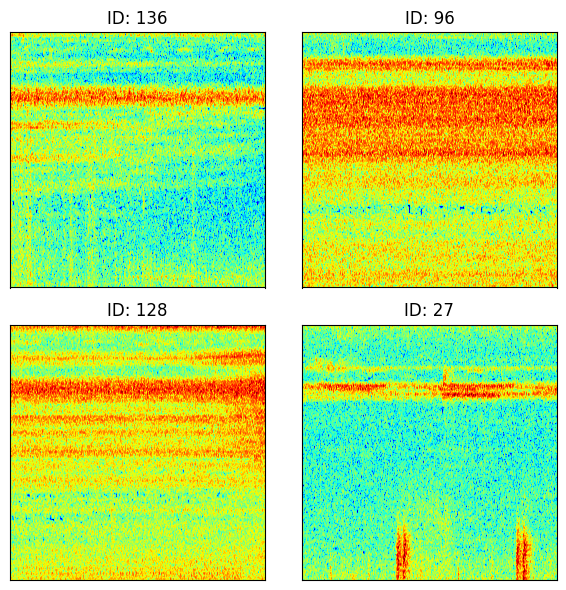

65379

In [9]:
dummy_dataset = BirdDataset(all_bird_data, get_transforms('test'))

test_input = dummy_dataset[0]
print(test_input.detach().numpy().shape)

if config.VISUALIZE:
    show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

# Model

## Network

In [10]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=False):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        
        return self.base_model(x)

## Model by PyTorch-Lightning

In [11]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(config.MODEL_TYPE, n_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=config.EPOCHS,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

# Functions of Inference Loop

In [12]:
def predict(data_loader, model):
    model.to(config.DEVICE)
    model.eval()
    pred = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x = batch
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        pred.append(outputs.detach().cpu())
    
    pred = torch.cat(pred, dim=0).cpu().detach()
    
    return pred.numpy().astype(np.float32)

# Inference & Submision

## ckpts

In [13]:
ckpt_list = [f'/kaggle/input/birdclef-2024-weights-4/fold_3.ckpt']

## Main Loop

In [14]:
predictions = []

for ckpt in ckpt_list:
    
    # == init model ==
    bird_model = BirdModel()
    
    # == load ckpt ==
    weights = torch.load(ckpt, map_location=torch.device('cpu'))['state_dict']
    bird_model.load_state_dict(weights)
    
    # == create dataset & dataloader ==
    test_dataset = BirdDataset(all_bird_data, get_transforms('test'))
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.N_WORKERS,
        shuffle=False,
        drop_last=False
    )
    
    predictions.append(predict(test_loader, bird_model))
    gc.collect()

predictions = np.mean(predictions, axis=0)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [15]:
sub_pred = pd.DataFrame(predictions, columns=label_list)
sub_id = pd.DataFrame({'row_id': list(all_bird_data.keys())})

sub = pd.concat([sub_id, sub_pred], axis=1)

sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head(5)

Submissionn shape: (480, 183)


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,1000170626_5,0.000892,0.000195,0.000417,0.000014,0.000895,7.330293e-07,0.000215,0.000343,0.000695,...,0.000047,0.000042,0.000629,0.000055,0.000931,0.049689,0.000003,0.000217,0.000016,0.005395
1,1000170626_10,0.002148,0.000198,0.001943,0.000069,0.002048,3.907369e-06,0.000693,0.000598,0.000343,...,0.000503,0.000121,0.001549,0.000121,0.003169,0.071572,0.000018,0.000181,0.000044,0.008921
2,1000170626_15,0.002123,0.000618,0.000697,0.000082,0.002067,1.635899e-06,0.002361,0.000180,0.000505,...,0.000183,0.000095,0.002615,0.000176,0.002218,0.027357,0.000015,0.000122,0.000018,0.005305
3,1000170626_20,0.000784,0.000494,0.002070,0.000084,0.003420,4.405439e-06,0.000437,0.000712,0.000302,...,0.000870,0.000161,0.001347,0.000188,0.003066,0.021047,0.000019,0.000303,0.000111,0.006561
4,1000170626_25,0.002298,0.000137,0.000430,0.000035,0.002060,1.291078e-06,0.000561,0.000124,0.000305,...,0.000792,0.000103,0.001195,0.000052,0.002166,0.036484,0.000003,0.000059,0.000022,0.019571
